<img src="pic10.png" width="600"/>

In [1]:
#Area and volume quantification
L=2.3
D1=0.9 #m bag
D2=0.955*2 #m tent
Deep =0.5 #m

Vd=Deep*D1*L*0.8*1000 #liter
Ak1=L*Deep*2+D1*L*0.9 #m2
Ah1=L*D1
Vbg=3.14*((D1/2)**2)*L*0.6*1000
Vt=0.5*3.14*((D2/2)**2)*(L+0.5)*1000-Vbg



In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

Write a linear interpolation function on the file combined_temperatures.csv. Convert the first colum to a variable in days, starting at 0 days and ending at the end date. Write a simple function where time in days and variable name eg c3l is specified and return the linearly interpolated of the defined name (like c3l) at the defined time. Import csv outside the function. So function has time in days and column name in combined_temperatures as input, and a single temperature vlaue as output.

In [6]:
# Read and preprocess data outside the function
df = pd.read_csv('combined_temperatures.csv', parse_dates=[0], index_col=0)

# Convert datetime index to days since start
start_date = df.index[0]
df['days'] = (df.index - start_date).total_seconds() / (24 * 3600)

# Pre-clean data: Store non-NaN values for each column
clean_data = {}
for col in df.columns:
    if col == 'days':  # Skip the days column
        continue
    mask = df[col].notna()
    clean_data[col] = {
        'days': df.loc[mask, 'days'].values,
        'values': df.loc[mask, col].values
    }

def interpolated_temperature(time_days, column_name):
    """
    Returns linearly interpolated temperature value at specified time
    
    Args:
        time_days: Time in days since start of dataset (float)
        column_name: Name of temperature column (e.g., 'c3l')
    
    Returns:
        Interpolated temperature (float)
    """
    # Validate column name
    if column_name not in clean_data:
        valid_cols = ', '.join([c for c in clean_data.keys()])
        raise ValueError(f"Invalid column name. Valid options: {valid_cols}")
    
    # Get clean data for this column
    data = clean_data[column_name]
    xp, fp = data['days'], data['values']
    
    # Handle out-of-range requests
    if time_days < xp[0]:
        return fp[0]
    if time_days > xp[-1]:
        return fp[-1]
    
    # Perform linear interpolation
    return np.interp(time_days, xp, fp)



In [10]:
# Get ambient temperature at 2.75 days
temp = interpolated_temperature(4, 'c3g')
temp

28.7

Use the already imported combined_temperatures.csv and generate a plot of time in days (not date but numerical value of days) against one of the temperature colums as specified by the column name in CSV file (colum 2-11). Keep short and neat. 

Available columns: ambient, soilcold, c2l, c2g, c2t, c2s, c3l, c3g, cst, c3s
Enter column name to plot: c2l


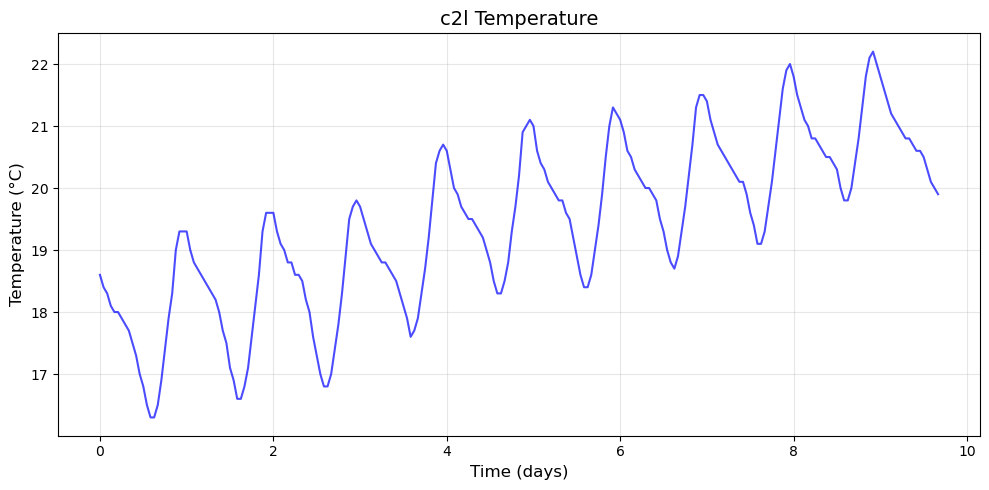

In [14]:
import matplotlib.pyplot as plt

# Load data and prepare time in days
df = pd.read_csv('combined_temperatures.csv', parse_dates=[0], index_col=0)
start = df.index[0]
df['days'] = (df.index - start).total_seconds() / 86400  # Removed .dt

# Get available columns
cols = [c for c in df.columns if c != 'days']
print(f"Available columns: {', '.join(cols)}")

# User selects column to plot
col = input("Enter column name to plot: ").strip()

# Create plot
plt.figure(figsize=(10, 5))
plt.plot(df['days'], df[col], 'b-', linewidth=1.5, alpha=0.7)
plt.title(f'{col} Temperature', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# Save and show
plt.savefig(f'{col}_plot.png', dpi=120)
plt.show()

Upload the julysun.csv and 7 Aug.csv files in python. Both files have time in days (from 0 to 1) in column 1 and the illuminance data in column two. We need to gererate a new CSV file from 29 July 00:00 (2025) to 8Aug 00:00. Each day except 7 Aug should repeat the data from julysun.csv, except 7 Aug which should have the data from 7 Aug.csv. Time zero is at 00:00 at night and time 1 is at 00:00 the next day. 

In [15]:
# Read the CSV files, skipping headers
julysun = pd.read_csv('julysun.csv', header=None, names=['time', 'illuminance'])
aug7 = pd.read_csv('7 Aug.csv', header=None, names=['time', 'illuminance'])

# Remove any potential point at exactly time=1.0 (next day 00:00)
julysun = julysun[julysun['time'] < 1.0]
aug7 = aug7[aug7['time'] < 1.0]

# Create an empty DataFrame for the final result
final_data = pd.DataFrame(columns=['time', 'illuminance'])

# Generate data for each day (29 July to 7 August)
for day in range(10):  # 10 days from 29 July to 7 August inclusive
    if day < 9:  # 29 July to 6 August - use July pattern
        day_data = julysun.copy()
    else:  # 7 August - use August pattern
        day_data = aug7.copy()
    
    # Adjust time: add day number to shift data
    day_data['time'] += day
    
    # Append to final data
    final_data = pd.concat([final_data, day_data])

# Add the final point at 8 August 00:00 (time = 10.0)
final_data = pd.concat([final_data, pd.DataFrame({'time': [10.0], 'illuminance': [0]})])

# Save to CSV
final_data.to_csv('illuminance_29jul_to_7aug.csv', index=False, header=False)
print("File saved: illuminance_29jul_to_7aug.csv")

File saved: illuminance_29jul_to_7aug.csv


Now write a function in python where the input is time in days (0-10) and where the illuminance data for that specific time is returned using illuminance_29jul_to_7aug.csv. 

In [16]:
# Preload data once for efficient repeated access
_data = np.loadtxt('illuminance_29jul_to_7aug.csv', delimiter=',')
_times = _data[:, 0]
_values = _data[:, 1]

def get_illuminance(time_days):
    """
    Returns illuminance value at specified time using linear interpolation
    
    Args:
        time_days: Time in days (0.0 to 10.0) since 29 July 00:00
    
    Returns:
        Interpolated illuminance value (float)
    """
    # Handle out-of-range requests
    if time_days < 0:
        return _values[0]
    if time_days > 10.0:
        return _values[-1]
    
    # Perform efficient linear interpolation
    return np.interp(time_days, _times, _values)

In [25]:
a=get_illuminance(7.4)
a

47616.191873899515

# Now the DE

In [158]:
h1=3*60*60*24/1000     #5 W/m2K  remember timescale per day
k1=0.3*60*60*24/1000*35   #W/mK 0.5m to Ts
a=0.42

In [159]:
def ebal(t,T):
    
    Tl = T[0] 
    
    Tg= interpolated_temperature(t, 'c2g')
    Ts= interpolated_temperature(t, 'c2s')
    Illum=get_illuminance(t)
    
    dTldt= (k1*Ak1*(Ts-Tl)+h1*Ah1*(Tg-Tl)+a*Illum)/(Vd*4.187)
    
        
    return dTldt;

In [160]:
To=[17.8]                    
tmax = 10                                
tspan=np.linspace(0,tmax,500)            
tper = (0,tmax)                          

Tsolve = solve_ivp(ebal, tper, To, dense_output = True, method = "LSODA")    # integration via odeint that calls apon response_fun

Tl = Tsolve.sol(tspan).T

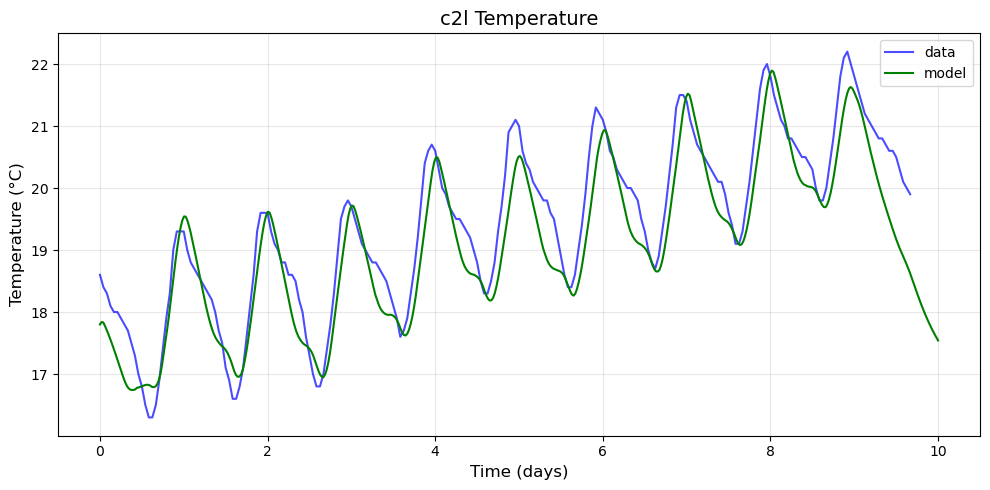

In [162]:
# Create plot
plt.figure(figsize=(10, 5))
plt.plot(df['days'], df[col], 'b-', linewidth=1.5, alpha=0.7, label='data')
plt.plot(tspan, Tl, color='green', label='model')

plt.title(f'{col} Temperature', fontsize=14)
plt.xlabel('Time (days)', fontsize=12)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.legend(loc='best')
plt.grid(alpha=0.3)
plt.tight_layout()